# Sheet 4

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## 3 QDA
### (a)

In [5]:
pts = np.load("data/data1d.npy")
labels = np.load("data/labels1d.npy")

In [ ]:
neg_pts = pts[labels == 0]
neg_mu = neg_pts.mean()
neg_sigma = neg_pts.std()

pos_pts = pts[labels == 1]
pos_mu = pos_pts.mean()
pos_sigma = pos_pts.std()

### (b)

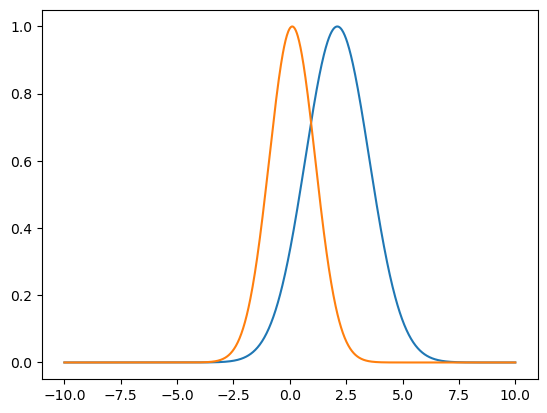

In [11]:
x_min = -10
x_max = 10

x = np.linspace(x_min, x_max, 1000)
y_pos = np.exp(-((x - pos_mu) ** 2) / (2 * pos_sigma**2))
y_neg = np.exp(-((x - neg_mu) ** 2) / (2 * neg_sigma**2))
plt.plot(x, y_pos)
plt.plot(x, y_neg)

## 4 Trees and Random Forests

### (b)

In [6]:
# load the data
pts = np.load("data/data1d.npy")
labels = np.load("data/labels1d.npy")

# TODO: Sort the points to easily split them
sorted_indices = np.argsort(pts)
pts = pts[sorted_indices]
labels = labels[sorted_indices]

# TODO: Implement or find implementation for Gini impurity, entropy and misclassifcation rate


def probabilities(partition):
    # divide counts by size of dataset to get cluster probabilites
    return np.unique(partition, return_counts=True)[1] / len(partition)


def compute_split_measure(l, l0, l1, method):
    p0 = probabilities(l0)
    p1 = probabilities(l1)
    p = probabilities(l)
    return method(p) - (len(l0) * method(p0) + len(l1) * method(p1)) / (len(l))


# TODO: Iterate over the possible splits, evaulating and saving the three criteria for each one
# TODO: Then, Compute the split that each criterion favours and visualize them
#       (e.g. with a histogram for each class and vertical lines to show the splits)

### (b)

In [7]:
# load the dijet data
features = np.load("data/dijet_features_normalized.npy")
labels = np.load("data/dijet_labels.npy")

# TODO: define train, val and test splits as specified (make sure to shuffle the data before splitting it!)

In [8]:
from sklearn.ensemble import RandomForestClassifier

# TODO: train a random forest classifier for each combination of specified hyperparameters
#       and evaluate the performances on the validation set.

In [9]:
# TODO: for your preferred configuration, evaluate the performance of the best configuration on the test set